# Nifty 50 Partial Replication

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, ParameterGrid
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("always", category=ConvergenceWarning)
import seaborn as sns
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel,mutual_info_regression

In [2]:
def tracking_error(y_true, y_pred):
    # Convert y_true and y_pred to pandas Series for easy handling of pct_change()
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    
    # Calculate percentage change for true values and predictions
    # pct_change_true = y_true.pct_change() * 100
    # pct_change_pred = y_pred.pct_change() * 100
    
    # Calculate the difference between the percentage changes
    diff_pct_change = y_true - y_pred    
    
    # Return the standard deviation of the differences (tracking error)
    return np.std(diff_pct_change.dropna())  # dropna() to avoid NaN values in pct_change

In [3]:
def adj_tracking_error(y_true, X_test, model):
    cost = 0.001  # 0.1% cost
    X_test_adjusted = X_test.copy()
    X_test_adjusted[0, :] -= cost  # Subtract cost from the first return of each stock

    # Predict with adjustment
    y_pred_adjusted = model.predict(X_test_adjusted)
    return tracking_error(y_true, y_pred_adjusted)

# Data

In [4]:
# directory_path = '/kaggle/input/stock-market-data-nifty-50-stocks-1-min-data'
# pattern = os.path.join(directory_path, "*.csv")  # Change "*.csv" to match other patterns if needed

# Get the list of files that match the pattern
# file_list = glob.glob(pattern)

In [5]:
def fetch_data(cols):
    df_list = []
    for file in tqdm(file_list):
        stock_name = os.path.basename(file).split("_")[0]
        file_df = pd.read_csv(file, index_col=0)
        file_df = file_df[[cols]]
        file_df.columns = pd.MultiIndex.from_product([[stock_name], file_df.columns])
        df_list.append(file_df)
    return pd.concat(df_list, axis=1)

In [6]:
# df = fetch_data('close')
# df.to_csv('/kaggle/input/nifty_50_closing.csv')

In [7]:
df = pd.read_csv('/kaggle/input/nifty-50-closing-data/nifty_50_closing.csv', index_col=0, header=[0, 1])
df = df.xs('close', level=1, axis=1)
df.index = pd.to_datetime(df.index)

nan_rows = df.isna().any(axis=1)

# Get the number of rows with NaN values
num_nan_rows = nan_rows.sum()

print(f"Number of rows with NaN values: {num_nan_rows}")

Number of rows with NaN values: 639555


In [8]:
nifty_100_closing = pd.read_csv('/kaggle/input/nifty-50-minute-data/NIFTY 100_minute.csv', index_col=0)[['close']]
nifty_100_closing.index = pd.to_datetime(nifty_100_closing.index)
nifty_100_closing.rename(columns={'close': 'NIFTY_100'}, inplace=True)

In [9]:
print(f"Index type for df1: {type(df.index)}")
print(f"Index type for df2: {type(nifty_100_closing.index)}")

Index type for df1: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type for df2: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [10]:
threshold = 0.10
# Drop columns with more than the threshold percentage of missing values
df = df.dropna(thresh=int((1-threshold) * len(df)), axis=1)

nan_rows = df.isna().any(axis=1)

# Get the number of rows with NaN values
num_nan_rows = nan_rows.sum()

print(f"Number of rows with NaN values: {num_nan_rows}")

df.dropna(axis=0, inplace=True)

df.index = df.index.tz_localize(None)

zero_rows = (df == 0.0).any(axis=1)

num_zero_rows = zero_rows.sum()

print(f"Number of rows with 0.0 values: {num_zero_rows}")
print(f"Total rows {len(df)}")

Number of rows with NaN values: 37207
Number of rows with 0.0 values: 79
Total rows 639981


In [11]:
len(df.columns)

88

In [12]:
df_total = df.join(nifty_100_closing, how='left')

In [13]:
df_total.dropna(inplace=True)

In [14]:
# Calculate the percentage change
X_pct_change = df_total.pct_change()

# Define the threshold for large changes (e.g., 100% change)
threshold = 1.0  # 1.0 corresponds to 100% when working with pct_change()

# Find rows with any column having a percentage change greater than the threshold
large_change_rows = X_pct_change[(X_pct_change.abs() > threshold).any(axis=1)]

# Get the number of rows where there are large percentage changes
num_large_changes = large_change_rows.shape[0]

print(f"Number of rows with large changes (>{threshold * 100}%): {num_large_changes}")

Number of rows with large changes (>100.0%): 42


In [15]:
print(len(df_total))

629791


In [16]:
df_total.sort_index(inplace=True)

In [17]:
from dateutil.relativedelta import relativedelta


df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = 100*df_total_returns
X = df_total_returns.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total_returns['NIFTY_100']

tscv = TimeSeriesSplit(n_splits=18, max_train_size=85000, test_size=30000)


# Iterate over each split
for train_index, test_index in tscv.split(X):
    # Get the date ranges for train and test indices
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]


    train_start = train_dates[0]
    train_end = train_dates[-1]
    test_start = test_dates[0]
    test_end = test_dates[-1]
    train_length = relativedelta(train_end, train_start)
    test_length = relativedelta(test_end, test_start)

    
    # Print the date ranges
    print(f"TRAIN: {train_start} to {train_end} "
          f"({train_length.years*12 + train_length.months} months, {train_length.days} days)")
    print(len(train_index))
    print(f"TEST: {test_start} to {test_end} "
          f"({test_length.years*12 + test_length.months} months, {test_length.days} days)")
    print(len(test_index))

TRAIN: 2015-02-19 15:12:00 to 2016-04-07 11:40:00 (13 months, 18 days)
85000
TEST: 2016-04-07 11:41:00 to 2016-08-16 10:27:00 (4 months, 8 days)
30000
TRAIN: 2015-06-29 13:49:00 to 2016-08-16 10:27:00 (13 months, 17 days)
85000
TEST: 2016-08-16 10:28:00 to 2016-12-22 13:19:00 (4 months, 6 days)
30000
TRAIN: 2015-12-17 14:02:00 to 2016-12-22 13:19:00 (12 months, 4 days)
85000
TEST: 2016-12-22 13:20:00 to 2017-05-02 12:41:00 (4 months, 9 days)
30000
TRAIN: 2016-04-29 14:28:00 to 2017-05-02 12:41:00 (12 months, 2 days)
85000
TEST: 2017-05-02 12:42:00 to 2017-09-06 14:52:00 (4 months, 4 days)
30000
TRAIN: 2016-09-02 13:10:00 to 2017-09-06 14:52:00 (12 months, 4 days)
85000
TEST: 2017-09-06 14:53:00 to 2018-01-11 12:46:00 (4 months, 4 days)
30000
TRAIN: 2017-01-11 09:49:00 to 2018-01-11 12:46:00 (12 months, 0 days)
85000
TEST: 2018-01-11 12:47:00 to 2018-05-24 10:55:00 (4 months, 12 days)
30000
TRAIN: 2017-05-22 09:20:00 to 2018-05-24 10:55:00 (12 months, 2 days)
85000
TEST: 2018-05-24 10:5

# Models

## Combined Approach
In this section, we will utilize a combined approach to limit the number of features (stocks) and train our models.

1. Feature Selection (using Lasso w/ high alpha, Mutual Info, ANOVA, RFE)
2. Define threshold to drop features
3. Train model on reduced feature space (Hyperparameter tuned)
4. Get tracking error
5. Save pair (number of stocks, tracking error) for plotting

### Lasso - Lasso

We will utilize a Lasso model with a high alpha value to perform feature selection, this will drop the coefficients for less important features to 0. After that we retrain a Lasso model with hyperparameter tuning.

In [18]:
from sklearn.preprocessing import StandardScaler

def Lasso_Lasso(alpha, X, y):    
    tscv = TimeSeriesSplit(n_splits=18, max_train_size=85000, test_size=30000)
    stocks = []
    num_stocks = []
    fold_scores = []
    adj_fold_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        train_period = X.iloc[train_index].index
        test_period = X.iloc[test_index].index
        
        # Convert to date format
        train_start_date, train_end_date = train_period.min(), train_period.max()
        test_start_date, test_end_date = test_period.min(), test_period.max()
        
        print(f"Train period: {train_start_date} to {train_end_date}")
        print(f"Test period: {test_start_date} to {test_end_date}")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)
        
        # Feature selection with alpha from list
        lasso_fs = Lasso(alpha=alpha, max_iter=200)
        lasso_fs.fit(X_scaled, y_train_cv)

        #for feature, coef in zip(X_train_cv.columns, lasso_fs.coef_):
        #    print(f"{feature}: {coef}")

        selector = SelectFromModel(lasso_fs, threshold=10e-10, max_features=None)  # Adjust threshold as needed
        X_selected_train = selector.transform(X_scaled)
        X_selected_test = selector.transform(X_test_cv)

        selected_features = np.where(selector.get_support())[0] 
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_alpha = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for alph in [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025]:
            lasso = Lasso(alpha=alph, max_iter=15000)
            lasso.fit(X_selected_train, y_train_cv)
    
            y_pred = lasso.predict(X_selected_test)
            fold_score = tracking_error(y_test_cv.values, y_pred)
            adj_fold_score = adj_tracking_error(y_test_cv.values, X_selected_test, lasso)
            # print(f"Alpha: {alpha}, Fold Score: {fold_score}")
    
            if fold_score < best_score:
                best_score = fold_score
                best_alpha = alpha
    
        print(f"Best Alpha for this fold: {best_alpha}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)
        adj_fold_scores.append(adj_fold_score)
        
    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)
    average_adj_score = np.mean(adj_fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)
    
    # Print the tracking error for this alpha
    print(f"Alpha: {alpha}, Average Tracking Error: {average_score}")
 
    return stocks, average_selected_features, average_score, average_adj_score

----------Starting alpha 0.001-------------
Train period: 2015-02-19 15:12:00 to 2016-04-07 11:40:00
Test period: 2016-04-07 11:41:00 to 2016-08-16 10:27:00
Selected 72 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.037633181024703796
Train period: 2015-06-29 13:49:00 to 2016-08-16 10:27:00
Test period: 2016-08-16 10:28:00 to 2016-12-22 13:19:00
Selected 73 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.05002580777829724
Train period: 2015-12-17 14:02:00 to 2016-12-22 13:19:00
Test period: 2016-12-22 13:20:00 to 2017-05-02 12:41:00
Selected 77 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.027979556706381723
Train period: 2016-04-29 14:28:00 to 2017-05-02 12:41:00
Test period: 2017-05-02 12:42:00 to 2017-09-06 14:52:00
Selected 78 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.026597014791040915
Train period: 2016-09-02 13:10:00 to 2017-09-06 14:52:00
Test period: 2017-09-06 14:53:00 to 2018-01-11 12:46:00
Selected 77 stocks
Best Alpha fo

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.355e-01, tolerance: 7.712e-02
  model = cd_fast.enet_coordinate_descent(


Selected 82 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.05863145944155975
Train period: 2019-08-07 14:46:00 to 2020-09-01 12:07:00
Test period: 2020-09-01 12:08:00 to 2021-01-11 09:37:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.647e-01, tolerance: 8.593e-02
  model = cd_fast.enet_coordinate_descent(


Selected 80 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.044096700259039646
Train period: 2020-01-03 15:00:00 to 2021-01-11 09:37:00
Test period: 2021-01-11 09:38:00 to 2021-05-24 12:49:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.981e-01, tolerance: 8.769e-02
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.050086035190358896
Train period: 2020-05-19 14:50:00 to 2021-05-24 12:49:00
Test period: 2021-05-24 12:50:00 to 2021-09-28 14:42:00
Selected 82 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.030757340205887607
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-02-07 13:31:00
Selected 81 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.04579371958235278
Train period: 2021-02-03 12:09:00 to 2022-02-07 13:31:00
Test period: 2022-02-07 13:32:00 to 2022-06-14 14:33:00
Selected 79 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.060257209593759534
Train period: 2021-06-17 10:05:00 to 2022-06-14 14:33:00
Test period: 2022-06-14 14:34:00 to 2022-10-24 19:14:00
Selected 81 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.04524760929993786
Alpha: 0.001, Average Tracking Error: 0.04681372080058052
----------Starting alpha 0.002------------

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.055e-01, tolerance: 7.712e-02
  model = cd_fast.enet_coordinate_descent(


Selected 77 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.058666363474652476
Train period: 2019-08-07 14:46:00 to 2020-09-01 12:07:00
Test period: 2020-09-01 12:08:00 to 2021-01-11 09:37:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e-01, tolerance: 8.593e-02
  model = cd_fast.enet_coordinate_descent(


Selected 78 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.04410105441920642
Train period: 2020-01-03 15:00:00 to 2021-01-11 09:37:00
Test period: 2021-01-11 09:38:00 to 2021-05-24 12:49:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.334e-01, tolerance: 8.769e-02
  model = cd_fast.enet_coordinate_descent(


Selected 78 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.05011654225189297
Train period: 2020-05-19 14:50:00 to 2021-05-24 12:49:00
Test period: 2021-05-24 12:50:00 to 2021-09-28 14:42:00
Selected 74 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.03077426850558198
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-02-07 13:31:00
Selected 69 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.045817492972453654
Train period: 2021-02-03 12:09:00 to 2022-02-07 13:31:00
Test period: 2022-02-07 13:32:00 to 2022-06-14 14:33:00
Selected 70 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.06029364138747186
Train period: 2021-06-17 10:05:00 to 2022-06-14 14:33:00
Test period: 2022-06-14 14:34:00 to 2022-10-24 19:14:00
Selected 72 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.045265389005964045
Alpha: 0.002, Average Tracking Error: 0.046853785444125905
----------Starting alpha 0.003------------

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.315e-01, tolerance: 7.712e-02
  model = cd_fast.enet_coordinate_descent(


Selected 68 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.0587350365585386
Train period: 2019-08-07 14:46:00 to 2020-09-01 12:07:00
Test period: 2020-09-01 12:08:00 to 2021-01-11 09:37:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.741e-01, tolerance: 8.593e-02
  model = cd_fast.enet_coordinate_descent(


Selected 74 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.044126474629450116
Train period: 2020-01-03 15:00:00 to 2021-01-11 09:37:00
Test period: 2021-01-11 09:38:00 to 2021-05-24 12:49:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.978e-01, tolerance: 8.769e-02
  model = cd_fast.enet_coordinate_descent(


Selected 73 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.050151999546022355
Train period: 2020-05-19 14:50:00 to 2021-05-24 12:49:00
Test period: 2021-05-24 12:50:00 to 2021-09-28 14:42:00
Selected 66 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.030782576316807985
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-02-07 13:31:00
Selected 60 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.045841223012119785
Train period: 2021-02-03 12:09:00 to 2022-02-07 13:31:00
Test period: 2022-02-07 13:32:00 to 2022-06-14 14:33:00
Selected 57 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.060353401770396775
Train period: 2021-06-17 10:05:00 to 2022-06-14 14:33:00
Test period: 2022-06-14 14:34:00 to 2022-10-24 19:14:00
Selected 59 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.04528875700686836
Alpha: 0.003, Average Tracking Error: 0.04690836818563035
----------Starting alpha 0.004-----------

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 7.712e-02
  model = cd_fast.enet_coordinate_descent(


Selected 64 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.058734819964909105
Train period: 2019-08-07 14:46:00 to 2020-09-01 12:07:00
Test period: 2020-09-01 12:08:00 to 2021-01-11 09:37:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.244e-01, tolerance: 8.593e-02
  model = cd_fast.enet_coordinate_descent(


Selected 66 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.044143758060400065
Train period: 2020-01-03 15:00:00 to 2021-01-11 09:37:00
Test period: 2021-01-11 09:38:00 to 2021-05-24 12:49:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.062e-01, tolerance: 8.769e-02
  model = cd_fast.enet_coordinate_descent(


Selected 68 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.05016769894271749
Train period: 2020-05-19 14:50:00 to 2021-05-24 12:49:00
Test period: 2021-05-24 12:50:00 to 2021-09-28 14:42:00
Selected 56 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.03079457274664715
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-02-07 13:31:00
Selected 54 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.04586312198584476
Train period: 2021-02-03 12:09:00 to 2022-02-07 13:31:00
Test period: 2022-02-07 13:32:00 to 2022-06-14 14:33:00
Selected 51 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.06037175430260273
Train period: 2021-06-17 10:05:00 to 2022-06-14 14:33:00
Test period: 2022-06-14 14:34:00 to 2022-10-24 19:14:00
Selected 50 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.04527338906600026
Alpha: 0.004, Average Tracking Error: 0.046965758461623666
----------Starting alpha 0.005-------------


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.526e-01, tolerance: 7.712e-02
  model = cd_fast.enet_coordinate_descent(


Selected 59 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.05872665169631603
Train period: 2019-08-07 14:46:00 to 2020-09-01 12:07:00
Test period: 2020-09-01 12:08:00 to 2021-01-11 09:37:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e-01, tolerance: 8.593e-02
  model = cd_fast.enet_coordinate_descent(


Selected 60 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.04416359245863733
Train period: 2020-01-03 15:00:00 to 2021-01-11 09:37:00
Test period: 2021-01-11 09:38:00 to 2021-05-24 12:49:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e-01, tolerance: 8.769e-02
  model = cd_fast.enet_coordinate_descent(


Selected 62 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.05019783268569499
Train period: 2020-05-19 14:50:00 to 2021-05-24 12:49:00
Test period: 2021-05-24 12:50:00 to 2021-09-28 14:42:00
Selected 50 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.030824610014860244
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-02-07 13:31:00
Selected 46 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.04588456622818864
Train period: 2021-02-03 12:09:00 to 2022-02-07 13:31:00
Test period: 2022-02-07 13:32:00 to 2022-06-14 14:33:00
Selected 43 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.060466337803125506
Train period: 2021-06-17 10:05:00 to 2022-06-14 14:33:00
Test period: 2022-06-14 14:34:00 to 2022-10-24 19:14:00
Selected 46 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.045288587705489804
Alpha: 0.005, Average Tracking Error: 0.04704430180990765
----------Starting alpha 0.006------------

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e-01, tolerance: 8.593e-02
  model = cd_fast.enet_coordinate_descent(


Selected 55 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.044214010196217894
Train period: 2020-01-03 15:00:00 to 2021-01-11 09:37:00
Test period: 2021-01-11 09:38:00 to 2021-05-24 12:49:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 8.769e-02
  model = cd_fast.enet_coordinate_descent(


Selected 55 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.05026100511808419
Train period: 2020-05-19 14:50:00 to 2021-05-24 12:49:00
Test period: 2021-05-24 12:50:00 to 2021-09-28 14:42:00
Selected 43 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.03081008576802596
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-02-07 13:31:00
Selected 36 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.04589270724098062
Train period: 2021-02-03 12:09:00 to 2022-02-07 13:31:00
Test period: 2022-02-07 13:32:00 to 2022-06-14 14:33:00
Selected 35 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.06043008103504899
Train period: 2021-06-17 10:05:00 to 2022-06-14 14:33:00
Test period: 2022-06-14 14:34:00 to 2022-10-24 19:14:00
Selected 42 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.04530097270375028
Alpha: 0.006, Average Tracking Error: 0.04706907061732945
----------Starting alpha 0.007-------------
T

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.664e-02, tolerance: 8.769e-02
  model = cd_fast.enet_coordinate_descent(


Selected 50 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.05027666017891358
Train period: 2020-05-19 14:50:00 to 2021-05-24 12:49:00
Test period: 2021-05-24 12:50:00 to 2021-09-28 14:42:00
Selected 38 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.030853579756827353
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-02-07 13:31:00
Selected 31 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.045855704256214956
Train period: 2021-02-03 12:09:00 to 2022-02-07 13:31:00
Test period: 2022-02-07 13:32:00 to 2022-06-14 14:33:00
Selected 32 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.06044191228815577
Train period: 2021-06-17 10:05:00 to 2022-06-14 14:33:00
Test period: 2022-06-14 14:34:00 to 2022-10-24 19:14:00
Selected 38 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.04532791959516311
Alpha: 0.007, Average Tracking Error: 0.04711071436120266
----------Starting alpha 0.008-------------

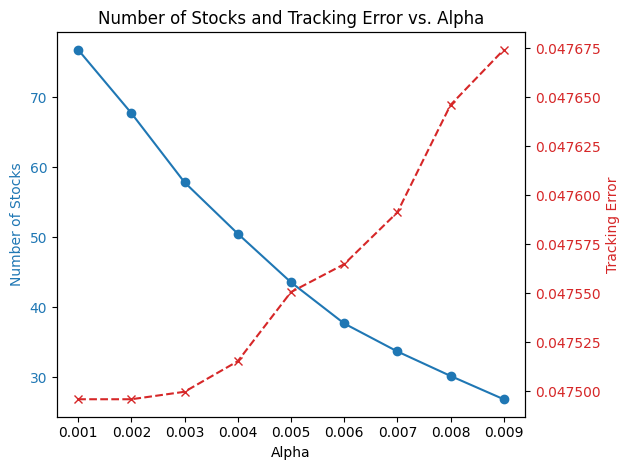

In [19]:
df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = 100*df_total_returns
X = df_total_returns.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total_returns['NIFTY_100']

alphas = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
tracking_errors = []
adj_tracking_errors = []
num_stocks_list = []

for alpha in alphas:
    print(f"----------Starting alpha {alpha}-------------")
    _, num_stocks, tracking_err, adj_tracking_err = Lasso_Lasso(alpha, X, y)
    num_stocks_list.append(num_stocks)
    tracking_errors.append(tracking_err)
    adj_tracking_errors.append(adj_tracking_err)

# Plotting the results
fig, ax1 = plt.subplots()

# Plotting number of stocks on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Number of Stocks', color=color)
ax1.plot(alphas, num_stocks_list, color=color, marker='o', label='Number of Stocks')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for tracking error
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Tracking Error', color=color)
#ax2.plot(alphas, tracking_errors, color='tab:green', marker='o', linestyle='--', label='Tracking Error')
ax2.plot(alphas, adj_tracking_errors, color=color, marker='x', linestyle='--', label='Adjusted Tracking Error')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title and legend
plt.title('Number of Stocks and Tracking Error vs. Alpha')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

0.048

### Mutual Info - Lasso
Using mutual information between variables, which measures the dependency between them, 0 value being independence. By getting the mutual information between the features (stocks) and the target (NIFTY 100) we can "discard" the variables with lower dependencies. After feature selection, we traing a Lasso model with CV.

In [20]:
from sklearn.preprocessing import StandardScaler

def MI_Experiment(percentile, X, y, model_class, params):
    tscv = TimeSeriesSplit(n_splits=18, max_train_size=85000, test_size=30000)
    stocks = []
    num_stocks = []
    fold_scores = []
    adj_fold_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)

        # Feature selection with alpha from list
        mi_scores = mutual_info_regression(X_train_cv, y_train_cv)
        mi_scores_series = pd.Series(mi_scores, index=X_train_cv.columns)

        threshold_value = mi_scores_series.quantile(percentile)
        
        selected_features = mi_scores_series[mi_scores_series > threshold_value].index
        selected_indices = [X_train_cv.columns.get_loc(feature) for feature in selected_features]

        # Filter the NumPy arrays based on the selected feature indices
        X_train_selected = X_scaled[:, selected_indices]
        X_test_selected = X_test_cv.to_numpy()[:, selected_indices]
    
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_params = None
        best_score = float('inf')  # Assuming lower is better for your metric
        best_adj_score = float('inf')
        for param in ParameterGrid(params):
            print(f"Trying combination {param}")
            model = model_class(**param)
            model.fit(X_train_selected, y_train_cv)
    
            y_pred = model.predict(X_test_selected)
            fold_score = tracking_error(y_test_cv.values, y_pred)
            adj_fold_score = adj_tracking_error(y_test_cv.values, X_test_selected, model)
            # print(f"Alpha: {alpha}, Fold Score: {fold_score}")
    
            if adj_fold_score < best_adj_score:
                best_score = fold_score
                best_adj_score = adj_fold_score
                best_params = param
    
        print(f"Best Params for this fold: {best_params}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)
        adj_fold_scores.append(best_adj_score)
        
    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)
    average_adj_score = np.mean(adj_fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)
    
    # Print the tracking error for this alpha
    print(f"Percentile: {percentile}, Tracking Error: {average_score}, Adj Tracking Error: {average_adj_score}")
 
    return stocks, average_selected_features, average_score, average_adj_score

Starting percentile: 0.0
Selected 85 stocks
Trying combination {'alpha': 0.0001, 'max_iter': 15000}
Trying combination {'alpha': 0.00025, 'max_iter': 15000}
Trying combination {'alpha': 0.0005, 'max_iter': 15000}
Trying combination {'alpha': 0.00075, 'max_iter': 15000}
Trying combination {'alpha': 0.001, 'max_iter': 15000}
Trying combination {'alpha': 0.002, 'max_iter': 15000}
Trying combination {'alpha': 0.0025, 'max_iter': 15000}
Best Params for this fold: {'alpha': 0.0001, 'max_iter': 15000}, Best Fold Score: 0.037605575453003165
Selected 85 stocks
Trying combination {'alpha': 0.0001, 'max_iter': 15000}
Trying combination {'alpha': 0.00025, 'max_iter': 15000}
Trying combination {'alpha': 0.0005, 'max_iter': 15000}
Trying combination {'alpha': 0.00075, 'max_iter': 15000}
Trying combination {'alpha': 0.001, 'max_iter': 15000}
Trying combination {'alpha': 0.002, 'max_iter': 15000}
Trying combination {'alpha': 0.0025, 'max_iter': 15000}
Best Params for this fold: {'alpha': 0.0001, 'max_

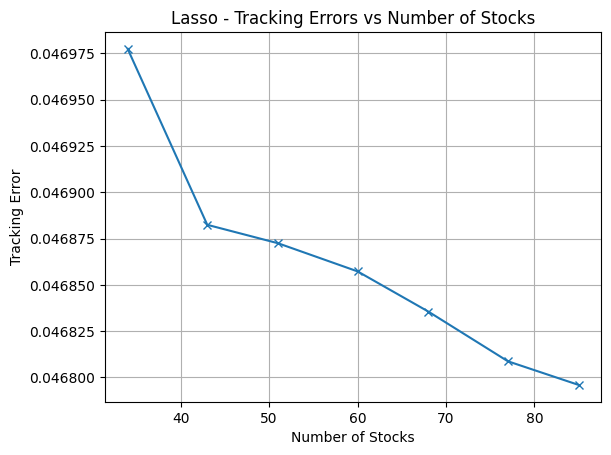

In [21]:
df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = 100*df_total_returns
X = df_total_returns.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total_returns['NIFTY_100']

tracking_errors = []
adj_tracking_errors = []
num_stocks_list = []

percentiles = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
param_grid = {
    'alpha': [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025],
    'max_iter': [15000]
}


for percentile in percentiles:
    print(f"Starting percentile: {percentile}")
    _, num_stocks, tracking_err, adj_tracking_err = MI_Experiment(percentile, X, y, Lasso, param_grid)
    num_stocks_list.append(num_stocks)
    tracking_errors.append(tracking_err)
    adj_tracking_errors.append(adj_tracking_err)

# Plotting the results
fig, ax1 = plt.subplots()

# Plotting number of stocks on the primary y-axis
plt.plot(num_stocks_list, adj_tracking_errors, marker='x')
plt.xlabel('Number of Stocks')
plt.ylabel('Tracking Error')
plt.title('Lasso - Tracking Errors vs Number of Stocks')
plt.grid(True)
plt.show()

### MI - Linear Regression

Starting percentile: 0.0
Selected 85 stocks
Trying combination {'alpha': 0.0001, 'l1_ratio': 0.1}
Trying combination {'alpha': 0.0001, 'l1_ratio': 0.5}
Trying combination {'alpha': 0.0001, 'l1_ratio': 0.7}
Trying combination {'alpha': 0.0001, 'l1_ratio': 0.9}
Trying combination {'alpha': 0.00025, 'l1_ratio': 0.1}
Trying combination {'alpha': 0.00025, 'l1_ratio': 0.5}
Trying combination {'alpha': 0.00025, 'l1_ratio': 0.7}
Trying combination {'alpha': 0.00025, 'l1_ratio': 0.9}
Trying combination {'alpha': 0.0005, 'l1_ratio': 0.1}
Trying combination {'alpha': 0.0005, 'l1_ratio': 0.5}
Trying combination {'alpha': 0.0005, 'l1_ratio': 0.7}
Trying combination {'alpha': 0.0005, 'l1_ratio': 0.9}
Trying combination {'alpha': 0.00075, 'l1_ratio': 0.1}
Trying combination {'alpha': 0.00075, 'l1_ratio': 0.5}
Trying combination {'alpha': 0.00075, 'l1_ratio': 0.7}
Trying combination {'alpha': 0.00075, 'l1_ratio': 0.9}
Trying combination {'alpha': 0.001, 'l1_ratio': 0.1}
Trying combination {'alpha': 0.

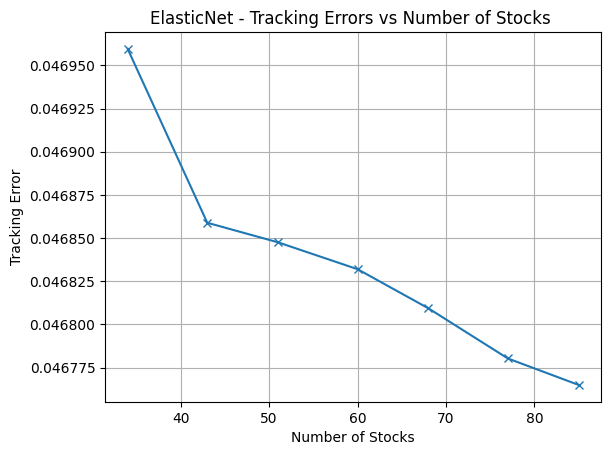

In [22]:
df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = 100*df_total_returns
X = df_total_returns.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total_returns['NIFTY_100']

tracking_errors = []
adj_tracking_errors = []
num_stocks_list = []

percentiles = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
param_grid = {
    'alpha': [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}


for percentile in percentiles:
    print(f"Starting percentile: {percentile}")
    _, num_stocks, tracking_err, adj_tracking_err = MI_Experiment(percentile, X, y, ElasticNet, param_grid)
    num_stocks_list.append(num_stocks)
    tracking_errors.append(tracking_err)
    adj_tracking_errors.append(adj_tracking_err)

# Plotting the results
fig, ax1 = plt.subplots()

# Plotting number of stocks on the primary y-axis
plt.plot(num_stocks_list, adj_tracking_errors, marker='x')
plt.xlabel('Number of Stocks')
plt.ylabel('Tracking Error')
plt.title('ElasticNet - Tracking Errors vs Number of Stocks ')
plt.grid(True)
plt.show()

TODO: Theil-Sein Linear Regression

Starting percentile: 0.5
Selected 43 stocks
Trying combination {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 0.6, 'n_estimators': 10, 'n_jobs': -1}
Trying combination {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 0.6, 'n_estimators': 15, 'n_jobs': -1}
Trying combination {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.6, 'n_estimators': 10, 'n_jobs': -1}
Trying combination {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.6, 'n_estimators': 15, 'n_jobs': -1}
Trying combination {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 0.6, 'n_estimators': 10, 'n_jobs': -1}
Trying combination {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 0.6, 'n_estimators': 15, 'n_jobs': -1}
Best Params for this fold: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 0.6, 'n_estimators': 10, 'n_jobs': -1}, Best 

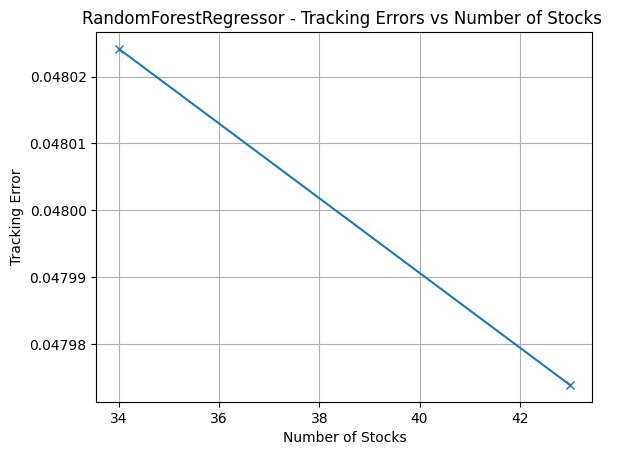

In [23]:
df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = 100*df_total_returns
X = df_total_returns.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total_returns['NIFTY_100']

tracking_errors = []
adj_tracking_errors = []
num_stocks_list = []

percentiles = [0.5, 0.6]
param_grid = {
    'n_estimators': [10, 15],       # Number of trees in the forest
    'max_depth': [None, 10, 20],      # Maximum depth of the tree
    'max_samples': [0.6],
    'bootstrap': [True],
    'n_jobs': [-1],
    'max_features': ['sqrt']
}


for percentile in percentiles:
    print(f"Starting percentile: {percentile}")
    _, num_stocks, tracking_err, adj_tracking_err = MI_Experiment(percentile, X, y, RandomForestRegressor, param_grid)
    num_stocks_list.append(num_stocks)
    tracking_errors.append(tracking_err)
    adj_tracking_errors.append(adj_tracking_err)

# Plotting the results
fig, ax1 = plt.subplots()

# Plotting number of stocks on the primary y-axis
plt.plot(num_stocks_list, adj_tracking_errors, marker='x')
plt.xlabel('Number of Stocks')
plt.ylabel('Tracking Error')
plt.title('RandomForestRegressor - Tracking Errors vs Number of Stocks ')
plt.grid(True)
plt.show()